# Task 2 : Sequence Task
For this Task we'll perform translation from French to English language. 

### Answer for Part 3 :
While it is possible to preprocess language data into a form that can be fed into an FF network for translation tasks, the architecture of FFNNs is not well-suited to handle the sequential, variable-length, and highly contextual nature of language. They lack the memory and statefulness required to effectively model the dependencies inherent in translation tasks (across words). Recurrent neural networks (RNNs), long short-term memory networks (LSTMs), gated recurrent units (GRUs) (and Transformer models) are better suited for these tasks due to their ability to handle sequential data, maintain context over long sequences, and dynamically manage variable-length input and output sequences. In a typical FF setting, we'll lose the auto-regressive patterns and the sequential dependencies. Each data-point will be treated as IID.

Note : The implementation takes inspiration from the Pytorch website tutorial. However significant changes are done for a more generalised and robust approach.

In [1]:
%matplotlib inline

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, random_split
from sklearn.model_selection import train_test_split

import requests
import os
from zipfile import ZipFile
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from nltk.translate.bleu_score import corpus_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# snippet to download the translation data from pytorch website (tutorial)
def download_and_extract(url='https://download.pytorch.org/tutorial/data.zip', extract_to='data/', target_file='eng-fra.txt'):
    os.makedirs(extract_to, exist_ok=True)
    print("Downloading the dataset...")
    response = requests.get(url)
    response.raise_for_status()
    zip_path = os.path.join(extract_to, 'data.zip')
    with open(zip_path, 'wb') as f:
        f.write(response.content)

    with ZipFile(zip_path, 'r') as zip_ref:
        txt_files = [f for f in zip_ref.namelist() if f.endswith('.txt')]
        if txt_files:
            target_path = os.path.join(extract_to, os.path.basename(txt_files[0]))
            print(f"Extracting to {target_path}...")
            with zip_ref.open(txt_files[0]) as zf, open(target_path, 'wb') as f:
                f.write(zf.read())
            print(f'File extracted successfully to {target_path}')
        else:
            print('No .txt file found in the archive.')
    os.remove(zip_path)
    return target_path

In [4]:
download_and_extract()

Extracting to data/eng-fra.txt...
File extracted successfully to data/eng-fra.txt


'data/eng-fra.txt'

Tokenization step. This is word level only, so doesnt need any in-depth tokenization process. For language, model needs to be aware of Start of Sentence and End of Sentence, these are presented as specialised tokens. Besides, an Unknown token is also usually included for the model to handle tokens which are not easy to handle. First, we need to create a Language structure which needs mappings from text to numerical/tensor. A simple method is to keep on indexing each word it sees and add it to dictionary. 

In [5]:
SOS_token = 0 # Start of Sentence token
EOS_token = 1 # End of sentence token
UNK_token = 2  # Unknown word token

class Lang: #a language class to structure each language corpus
    def __init__(self, name):
        self.name = name
        self.word2index = {"UNK": UNK_token}
        self.word2count = {"UNK": 0}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS", UNK_token: "UNK"}
        self.n_words = 3  # Count SOS, EOS, and UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words #bag of words indexing
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Then, we perform some basic cleaning up and normalization, typical of NLP tasks. COnverting to ASCII seems to be important as well.

In [6]:
def clean_string(s):
    s = ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn') #convert to ascii
    s = s.lower().strip() #lowercase
    s = re.sub(r"([.!?])", r" \1", s) #trim
    s = re.sub(r"[^a-zA-Z.!?\s]+", r" ", s) #remove non alpha
    return s.strip()

def readLangs(lang1, lang2, reverse=False): # convert the text file with language pairs to Languae class.
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').read().strip().split('\n') # Read the file and split into lines
    pairs = [[clean_string(s) for s in l.split('\t')] for l in lines] #separated by a tab

    if reverse: # Sometimes needed for other way translation.
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs #Language class of both language and the clean data

We are keeping our implementation less computationally intensive, so we will filter a subset from the original data. Namely, we will include sentences with max length 10 and with specific prefixes. (Guidelines from pytorch tutorial)

In [7]:
MAX_LENGTH = 10
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

Now we streamline and prepare the language classes by going through the data. Some sample stats is shown below.

In [8]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse) #read data

    print(f"In total, {len(pairs)} language pairs were in original data.")
    pairs = filterPairs(pairs)
    print(f"Following filtering, this was reduced to {len(pairs)} sentences.")
    for pair in pairs:
        input_lang.addSentence(pair[0]) #first part of line
        output_lang.addSentence(pair[1]) # later part of line

    print(f"Translating from {input_lang.name} to {output_lang.name}.")
    print("Total number of words :")
    print(f"{input_lang.name}\t:\t{input_lang.n_words}")
    print(f"{output_lang.name}\t:\t{output_lang.n_words}")
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(f"Random Sample : {random.choice(pairs)}")

In total, 135842 language pairs were in original data.
Following filtering, this was reduced to 10434 sentences.
Translating from fra to eng.
Total number of words :
fra	:	4358
eng	:	2796
Random Sample : ['je ne suis pas docteur .', 'i m not a doctor .']


Following will be our RNN model. Again, the sequence layer can be alternated between Vanilla RNN, LSTM and GRU using a parameter. An embedding layer applied on the input, followed by a dropout and then RNN layer is used.

In [9]:
class EncoderRNN(nn.Module): #Encoder model
    def __init__(self, input_size, hidden_size, rnn_type='rnn', dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)

        # assign the RNN layer type based on rnn_type
        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        elif rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.rnn(embedded)
        return output, hidden

Corresponding Decoder model is implemented below. Some additional modifications is included in forward method for generating text from the trained model . During the forward pass, the decoder iterates over each time step, using the output of the encoder as the initial hidden state, and generating a sequence of outputs. Depending on whether it is training or inference mode (target_tensor is provided or not), it either feeds the target tensor at the current time step as the next input (teacher forcing) or uses its own previous output as the next input. For LSTM, it handles both hidden and cell states; otherwise, it works with a single hidden state. The outputs across all time steps are concatenated and passed through a log softmax function to produce a probability distribution over the target vocabulary for each time step.

In [10]:
class DecoderRNN(nn.Module): #Decoder model
    def __init__(self, hidden_size, output_size, rnn_type='rnn'):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_type = rnn_type

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        # assign the RNN layer type
        if rnn_type == 'lstm':
            self.rnn = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        elif rnn_type == 'gru':
            self.rnn = nn.GRU(hidden_size, hidden_size, batch_first=True)
        elif rnn_type == 'rnn':
            self.rnn = nn.RNN(hidden_size, hidden_size, batch_first=True)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=encoder_outputs.device).fill_(SOS_token)

        if self.rnn_type == 'lstm':
            # LSTM expects a tuple of (hidden_state, cell_state)
            if isinstance(encoder_hidden, tuple):  # Encoder is LSTM
                decoder_hidden = encoder_hidden
            else:  # Encoder might not be LSTM
                decoder_hidden = (encoder_hidden, torch.zeros_like(encoder_hidden))
        else:
            decoder_hidden = encoder_hidden

        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1)
            else:
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden#, None

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)
        output = self.out(output)
        return output, hidden

Following functions are the pipeline for preparing and preprocessing the data to be fed inside the model. 

In [12]:
# Converts a sentence into a list of indices based on a given language's word-to-index mapping
# Allows unknown words. 
def sentence_to_idx(lang, sentence):
    return [lang.word2index[word] if word in lang.word2index else UNK_token for word in sentence.split(' ')]

# Transforms a sentence into a PyTorch tensor of indices, appending an end-of-sentence token
def sentence_to_tensor(lang, sentence, device='cuda'):
    indexes = sentence_to_idx(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(1, -1).to(device)

# Reverses the index-to-tensor process to convert a tensor of word indices back into a human-readable sentence, stopping when an EOS_token is encountered.
def tensor_to_sentence(lang, tensor):
    sentence = []
    for idx in tensor:
        if idx.item() == EOS_token:
            break  # Stop adding words once EOS_token is encountered
        if idx.item() in lang.index2word:
            sentence.append(lang.index2word[idx.item()])
    return ' '.join(sentence)

# Splits a dataset of sentence pairs into training, validation, and test sets
def split_data(pairs, test_size=0.3, val_size=0.5):
    train_pairs, test_val_pairs = train_test_split(pairs, test_size=test_size) # Split pairs into training and test+validation
    test_pairs, val_pairs = train_test_split(test_val_pairs, test_size=val_size) # Split test+validation into test and validation
    return train_pairs, test_pairs, val_pairs

# Converts pairs of sentences (input and target) into PyTorch tensors
def pairs_to_dataset(pairs, input_lang, output_lang, device='cuda'):
    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int64)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int64)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = sentence_to_idx(input_lang, inp) + [EOS_token]
        tgt_ids = sentence_to_idx(output_lang, tgt) + [EOS_token]
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    input_tensor = torch.tensor(input_ids).to(device)
    target_tensor = torch.tensor(target_ids).to(device)
    dataset = TensorDataset(input_tensor, target_tensor)
    return dataset

# Organizes the datasets into DataLoader objects
def create_dataloaders(input_lang, output_lang, train_pairs, test_pairs, val_pairs, batch_size=64, device='cuda'):
    train_dataset = pairs_to_dataset(train_pairs, input_lang, output_lang)
    test_dataset = pairs_to_dataset(test_pairs, input_lang, output_lang)
    val_dataset = pairs_to_dataset(val_pairs, input_lang, output_lang)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader, val_dataloader

# snippet to print from sample outputs
def print_sample_from_dataloader(input_lang, output_lang, dataloader, name):
    for input_tensor, target_tensor in dataloader:
        # Just take the first sample from this batch
        input_sentence = tensor_to_sentence(input_lang, input_tensor[0].to('cpu'))
        target_sentence = tensor_to_sentence(output_lang, target_tensor[0].to('cpu'))
        print(f"{name} DataLoader sample:")
        print(f"Input sentence: {input_sentence}")
        print(f"Target sentence: {target_sentence}\n")
        break  # Only process the first batch

In [13]:
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
train_pairs, test_pairs, val_pairs = split_data(pairs)
train_dataloader, test_dataloader, val_dataloader = create_dataloaders(input_lang, output_lang, train_pairs, test_pairs, val_pairs)

In total, 135842 language pairs were in original data.
Following filtering, this was reduced to 10434 sentences.
Translating from fra to eng.
Total number of words :
fra	:	4358
eng	:	2796


In [14]:
print_sample_from_dataloader(input_lang, output_lang, train_dataloader, "Train")
print_sample_from_dataloader(input_lang, output_lang, test_dataloader, "Test")
print_sample_from_dataloader(input_lang, output_lang, val_dataloader, "Validation")

Train DataLoader sample:
Input sentence: il est coupable de meurtre .
Target sentence: he is guilty of murder .

Test DataLoader sample:
Input sentence: nous sommes prudents .
Target sentence: we re careful .

Validation DataLoader sample:
Input sentence: je suis plus petit que toi .
Target sentence: i m shorter than you .



Following are the training and validation process for single epoch. For evaluation, we observe the loss function and the BLEU score. 
- NLLLoss (Negative Log Likelihood Loss) : This is used where outputs are a probability distribution across classes. In our case it's words in a vocabulary.
- BLEU Score (Bilingual Evaluation Understudy) : BLEU score is a metric for evaluating a generated sentence to a reference sentence. It quantifies the match between a machine's output and human translations, taking into account the precision of matched n-grams in the candidate text against the references. Scores range from 0 to 1, where higher scores indicate better match between the machine-generated output and the reference translations.

In [15]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0
    for input_tensor, target_tensor in dataloader:
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        encoder_optimizer.zero_grad()  # zero the gradient buffers
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
        loss.backward()

        encoder_optimizer.step()  # optimizes encoder's parameters
        decoder_optimizer.step()  # optimizes decoder's parameters

        total_loss += loss.item()

    return total_loss / len(dataloader)


def validate_epoch(dataloader, encoder, decoder, criterion):
    total_loss = 0
    references = []
    candidates = []

    with torch.no_grad():
        for input_tensor, target_tensor in dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
            total_loss += loss.item()

            # Calculate BLEU score
            for i in range(target_tensor.size(0)):  # Iterate over each item in the batch
                target_sentence = tensor_to_sentence(output_lang, target_tensor[i])
                predicted_indices = decoder_outputs[i].argmax(dim=1)
                predicted_sentence = tensor_to_sentence(output_lang, predicted_indices)

                references.append([target_sentence.split()])
                candidates.append(predicted_sentence.split())
    bleu_score = corpus_bleu(references, candidates)  # Calculate BLEU score
    return total_loss / len(dataloader), bleu_score

In [17]:
def train(train_dataloader, val_dataloader, encoder, decoder, n_epochs, learning_rate=0.001):
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    print_plot_loss_total = 0  # Accumulate loss here for averaging

    plot_train_losses = []  # Losses for plotting
    plot_val_losses = []
    plot_bleu_scores = []  # BLEU scores for plotting

    pbar = tqdm(range(1, n_epochs + 1), desc='Training Progress')
    for epoch in pbar:
        train_loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)  # Train for one epoch
        val_loss, bleu_score = validate_epoch(val_dataloader, encoder, decoder, criterion)  # Validate after each epoch

        #print_plot_loss_total += train_loss
        plot_train_losses.append(train_loss)

        plot_val_losses.append(val_loss)  # Append validation loss to list for plotting
        plot_bleu_scores.append(bleu_score)  # Append BLEU score to list for plotting
        #tqdm.write(f'Epoch: {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, BLEU Score: {bleu_score:.4f}')
        pbar.set_postfix({'Train Loss': f'{train_loss:.4f}', 'Val Loss': f'{val_loss:.4f}', 'BLEU': f'{bleu_score:.4f}'})


    # Plotting
    plt.figure(figsize=(20, 5))

    # Plot for training and validation loss
    plt.subplot(1, 2, 1)
    epochs_range = list(range(1, n_epochs + 1))
    plt.plot(epochs_range, plot_train_losses, label='Training Loss')
    plt.plot(epochs_range, plot_val_losses, label='Validation Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot for BLEU scores
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, plot_bleu_scores, label='BLEU Score', color='green', linestyle='--')
    plt.xlabel('Epochs')
    plt.ylabel('BLEU Score')
    plt.title('BLEU Score Over Epochs')
    plt.legend()

    plt.show()

In [18]:
def evaluate_test_set(test_dataloader, encoder, decoder, criterion, output_lang):
    total_loss = 0
    references = []
    candidates = []
    with torch.no_grad():
        for input_tensor, target_tensor in test_dataloader:
            input_tensor = input_tensor.to(device)
            target_tensor = target_tensor.to(device)

            encoder_outputs, encoder_hidden = encoder(input_tensor)
            decoder_outputs, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

            loss = criterion(decoder_outputs.view(-1, decoder_outputs.size(-1)), target_tensor.view(-1))
            total_loss += loss.item()

            for i in range(target_tensor.size(0)):
                target_sentence = tensor_to_sentence(output_lang, target_tensor[i])
                predicted_indices = decoder_outputs[i].argmax(dim=1)
                predicted_sentence = tensor_to_sentence(output_lang, predicted_indices)

                references.append([target_sentence.split()])
                candidates.append(predicted_sentence.split())

    bleu_score = corpus_bleu(references, candidates)
    avg_loss = total_loss / len(test_dataloader)
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test BLEU Score: {bleu_score:.4f}")


def translate_from_loader(dataloader, encoder, decoder, input_lang, output_lang, num_sentences=5):
    encoder.eval()  # Set encoder to evaluation mode
    decoder.eval()  # Set decoder to evaluation mode
    translations = []

    with torch.no_grad():
        for i, (input_tensor, target_tensor) in enumerate(dataloader):
            if i >= num_sentences:  # Translate only the specified number of sentences
                break

            # Ensure input tensor is suitable for a single sentence
            for j in range(input_tensor.size(0)):  # Iterate through each sentence in the batch
                if j >= num_sentences:
                    break  # Only translate the specified number of sentences

                input_sentence = tensor_to_sentence(input_lang, input_tensor[j])
                target_sentence = tensor_to_sentence(output_lang, target_tensor[j])
                single_input_tensor = input_tensor[j].unsqueeze(0).to(device)  # Add batch dimension

                # Encoding
                encoder_output, encoder_hidden = encoder(single_input_tensor)

                # Decoding
                decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS_token

                # Adjusting for LSTM's expected hidden state shape if necessary
                if isinstance(encoder_hidden, tuple):  # LSTM
                    decoder_hidden = (encoder_hidden[0][:, :1, :], encoder_hidden[1][:, :1, :])  # Reduce batch size to 1 for LSTM
                else:  # GRU or RNN
                    decoder_hidden = encoder_hidden[:, :1, :]  # Reduce batch size to 1

                decoded_words = []
                for di in range(MAX_LENGTH):
                    decoder_output, decoder_hidden = decoder.forward_step(decoder_input, decoder_hidden)
                    topv, topi = decoder_output.topk(1)
                    if topi.item() == EOS_token:
                        break
                    else:
                        decoded_words.append(output_lang.index2word[topi.item()])

                    decoder_input = topi.squeeze().detach().view(1, -1)

                output_sentence = ' '.join(decoded_words)
                translations.append((input_sentence, output_sentence, target_sentence))
                if j >= num_sentences - 1:  # Break if the specified number of sentences have been translated
                    break

    return translations

cuda


Training Progress:   0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
Training Progress: 100%|██████████| 100/100 [03:57<00:00,  2.38s/it, Train Loss=0.4019, Val Loss=1.6289, BLEU=0.2498]


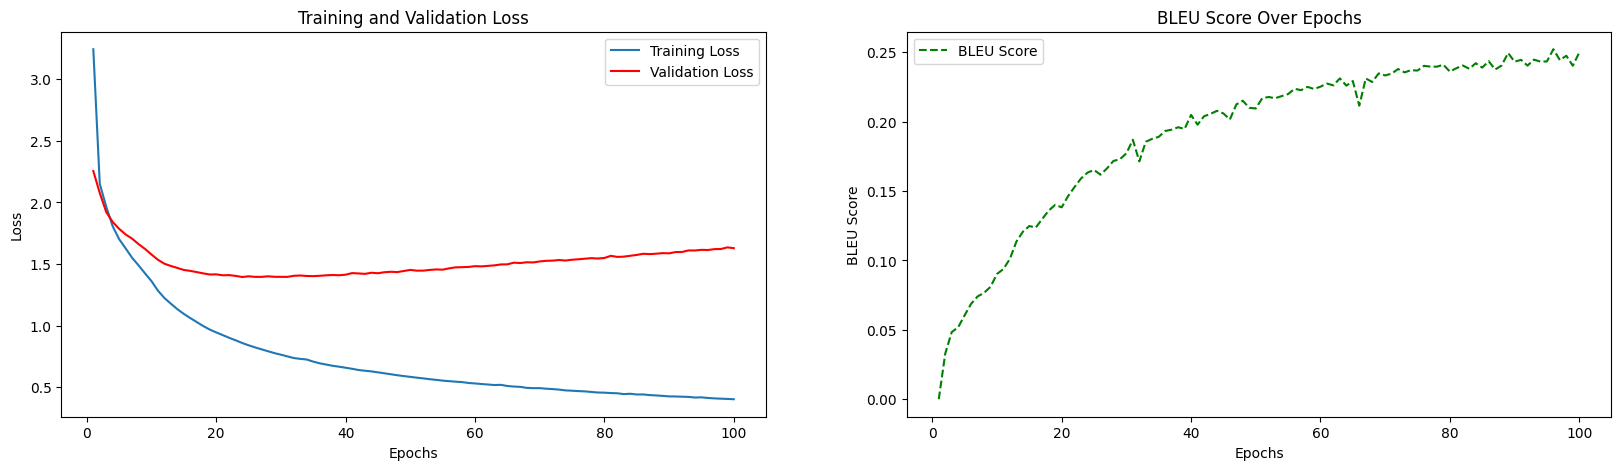

Test Loss: 1.5826
Test BLEU Score: 0.2563
Input: nous sommes prudents .
Output: we re alone .
Target: we re careful .
---
Input: je suis pensionnee .
Output: i m drunk .
Target: i m retired .
---
Input: il est ton ami .
Output: he is quite right .
Target: he s your friend .
---
Input: vous n etes pas un medecin .
Output: you re not very good .
Target: you are not a doctor .
---
Input: j en ai fini .
Output: i m your friend .
Target: i m through .
---
Input: je ne vais pas m asseoir ici .
Output: i m not selling you my car .
Target: i m not sitting here .
---
Input: elle est gracieuse .
Output: she is hard at work .
Target: she is graceful .
---
Input: je suis deja rassasie  merci beaucoup .
Output: i m done with all that .
Target: i m already full  thank you .
---
Input: je suis meticuleux .
Output: i m drunk .
Target: i m finicky .
---
Input: je chante avec mes enfants .
Output: i m beginning to get curious .
Target: i am singing with my children .
---
Input: elles sont toutes a moi .

In [19]:
hidden_size = 128
batch_size = 32

print(device)
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, val_dataloader, encoder, decoder, 100, learning_rate=0.001)

evaluate_test_set(test_dataloader, encoder, decoder, nn.NLLLoss(), output_lang)
translations = translate_from_loader(test_dataloader, encoder, decoder, input_lang, output_lang, num_sentences=5)
for input_sentence, output_sentence, target_sentence in translations:
    print('Input:', input_sentence)
    print('Output:', output_sentence)
    print('Target:', target_sentence)
    print('---')

Training Progress: 100%|██████████| 100/100 [04:02<00:00,  2.42s/it, Train Loss=0.0276, Val Loss=1.3796, BLEU=0.4392]


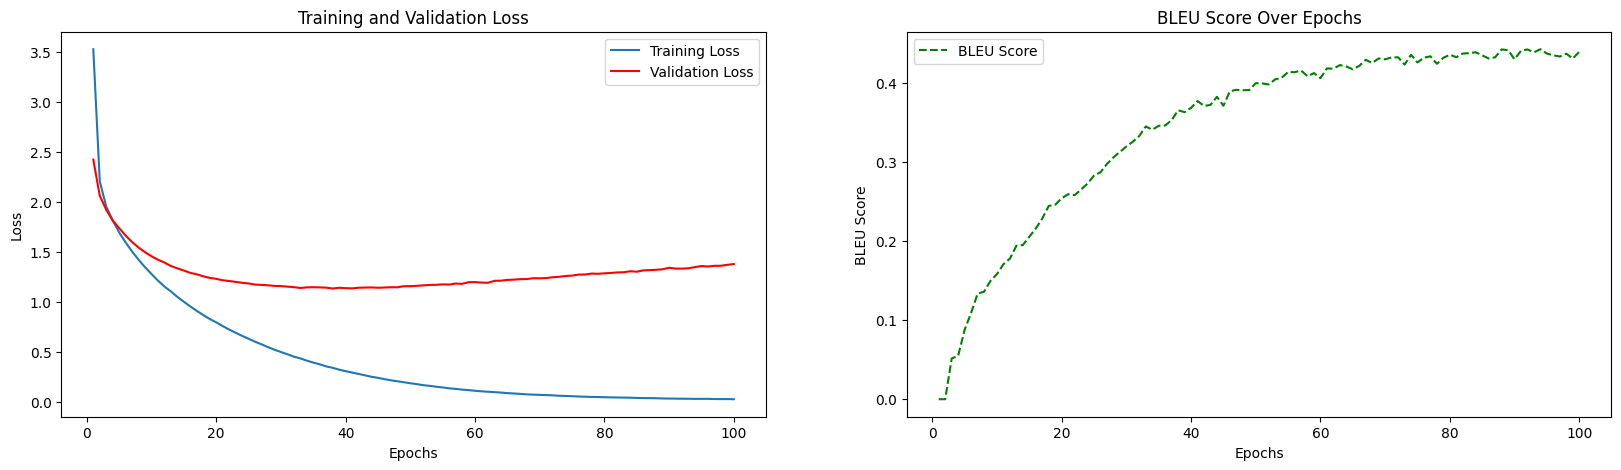

Test Loss: 1.3149
Test BLEU Score: 0.4625
Input: nous sommes prudents .
Output: we re careful .
Target: we re careful .
---
Input: je suis pensionnee .
Output: i am poor .
Target: i m retired .
---
Input: il est ton ami .
Output: he s your friend .
Target: he s your friend .
---
Input: vous n etes pas un medecin .
Output: you re not a doctor .
Target: you are not a doctor .
---
Input: j en ai fini .
Output: i m done with it .
Target: i m through .
---
Input: je ne vais pas m asseoir ici .
Output: i m not going to leave here .
Target: i m not sitting here .
---
Input: elle est gracieuse .
Output: she is a typist .
Target: she is graceful .
---
Input: je suis deja rassasie  merci beaucoup .
Output: i m worried  actually him .
Target: i m already full  thank you .
---
Input: je suis meticuleux .
Output: i m a foreigner .
Target: i m finicky .
---
Input: je chante avec mes enfants .
Output: i am new in the store .
Target: i am singing with my children .
---
Input: elles sont toutes a moi .

In [20]:
hidden_size = 128
batch_size = 32

encoder = EncoderRNN(input_lang.n_words, hidden_size, rnn_type='lstm').to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words, rnn_type='lstm').to(device)

#train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)
train(train_dataloader, val_dataloader, encoder, decoder, 100, learning_rate=0.001)

evaluate_test_set(test_dataloader, encoder, decoder, nn.NLLLoss(), output_lang)
translations = translate_from_loader(test_dataloader, encoder, decoder, input_lang, output_lang, num_sentences=5)
for input_sentence, output_sentence, target_sentence in translations:
    print('Input:', input_sentence)
    print('Output:', output_sentence)
    print('Target:', target_sentence)
    print('---')

Training Progress: 100%|██████████| 100/100 [04:00<00:00,  2.40s/it, Train Loss=0.0358, Val Loss=1.5719, BLEU=0.4001]


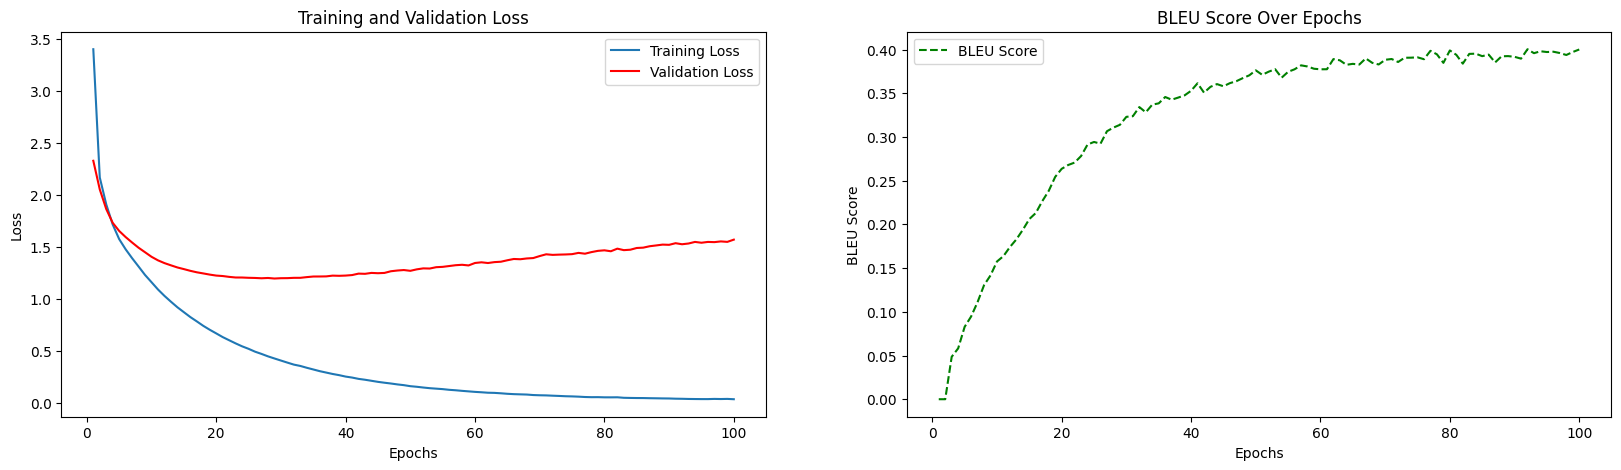

Test Loss: 1.5543
Test BLEU Score: 0.4188
Input: nous sommes prudents .
Output: we re punctual .
Target: we re careful .
---
Input: je suis pensionnee .
Output: i m outraged .
Target: i m retired .
---
Input: il est ton ami .
Output: he s your friend .
Target: he s your friend .
---
Input: vous n etes pas un medecin .
Output: you re not a doctor .
Target: you are not a doctor .
---
Input: j en ai fini .
Output: i m done with it .
Target: i m through .
---
Input: je ne vais pas m asseoir ici .
Output: i m not feeling particularly hungry .
Target: i m not sitting here .
---
Input: elle est gracieuse .
Output: she s hyperactive .
Target: she is graceful .
---
Input: je suis deja rassasie  merci beaucoup .
Output: i m very proud of you  .
Target: i m already full  thank you .
---
Input: je suis meticuleux .
Output: i m serious .
Target: i m finicky .
---
Input: je chante avec mes enfants .
Output: i m turning thirty .
Target: i am singing with my children .
---
Input: elles sont toutes a m

In [21]:
hidden_size = 128
batch_size = 32

encoder = EncoderRNN(input_lang.n_words, hidden_size, rnn_type='gru').to(device)
decoder = DecoderRNN(hidden_size, output_lang.n_words, rnn_type='gru').to(device)

#train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)
train(train_dataloader, val_dataloader, encoder, decoder, 100, learning_rate=0.001)

evaluate_test_set(test_dataloader, encoder, decoder, nn.NLLLoss(), output_lang)
translations = translate_from_loader(test_dataloader, encoder, decoder, input_lang, output_lang, num_sentences=5)
for input_sentence, output_sentence, target_sentence in translations:
    print('Input:', input_sentence)
    print('Output:', output_sentence)
    print('Target:', target_sentence)
    print('---')

| Model | Training Loss | Validation Loss | Test Loss | BLEU Score (Validation) | BLEU Score (Test) |
|-------|---------------|-----------------|-----------|-------------------------|-------------------|
| RNN   | 0.4019        | 1.6289          | 1.5826    | 0.2498                  | 0.2563            |
| LSTM  | 0.0276        | 1.3796          | 1.3149    | 0.4392                  | 0.4625            |
| GRU   | 0.0358        | 1.5719          | 1.5543    | 0.4001                  | 0.4188            |


Across models, the quality of translation varies significantly, with LSTM generally producing translations that are closer to the target sentences. RNNs, while faster to train, struggle with accuracy, especially in longer sentences or where context is long. GRUs find a middle ground between LSTM's accuracy and RNN's simplicity.

- RNN model shows a training loss of 0.4019, validation loss of 1.6289, and a BLEU score of 0.2498, with a slight improvement in the test BLEU score to 0.2563. These metrics indicate moderate learning during training but show limitations in capturing long-term dependencies, as seen in lower BLEU scores and inaccuracies in the translation outputs (e.g., translating "nous sommes prudents ." as "we re alone ." instead of "we re careful .").
- LSTM model, with a training loss of 0.0276, validation loss of 1.3796, and a BLEU score of 0.4392, exhibits superior performance compared to the RNN. The test BLEU score further improves to 0.4625. It has more accurate translations, such as correctly translating "nous sommes prudents ." to "we re careful .";  "nous sommes desoles pour le derangement" to "we are sorry for the inconvenience" ; "il est ton ami" to "he s your friend ."
- GRU model records a training loss of 0.0358, validation loss of 1.5719, and a BLEU score of 0.4001, with the test BLEU score at 0.4188. While the GRU model outperforms the RNN, it slightly lags behind the LSTM. Although it's not too bad with some translations like "vous etes maigrichon" to "you re skinny".

IN general, all the models would benefit from more training. These models were trained only for 100 epochs.